In [1]:
###########import packages##########
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import ensemble
from sklearn.tree import ExtraTreeRegressor
from sklearn import svm
from sklearn import neighbors
from sklearn import tree
from sklearn import ensemble
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.model_selection import LeaveOneOut
seed=911
###########import packages##########
import catboost
import xgboost
import lightgbm
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import *
import pickle
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import  *

In [2]:
###########wrapping root mean square error for later calls##########
def compute_mae_mse_rmse(target,prediction):
    error = []
    for i in range(len(target)):
        error.append(target[i] - prediction[i])
    squaredError = []
    absError = []
    for val in error:
        squaredError.append(val * val)  # target-prediction之差平方
        absError.append(abs(val))  # 误差绝对值
    mae=sum(absError)/len(absError)  # 平均绝对误差MAE
    mse=sum(squaredError)/len(squaredError)  # 均方误差MSE
    RMSE=np.sqrt(sum(squaredError)/len(squaredError))
    R2=r2_score(target,prediction)
    return mae,mse,RMSE,R2
def gridsearch(model,param,algorithm_name,X_train,y_train,X_test,y_test):
    grid = GridSearchCV(model,param_grid=param,scoring='neg_mean_absolute_error',cv=10,n_jobs=-1,verbose=-1)
    grid.fit(X_train,y_train)
    best_model=grid.best_estimator_
    ####Train####
    prediction_train = best_model.predict(X_train)
    real_train=y_train.values
    prediction_train_series=pd.Series(prediction_train)
    real_train_series=pd.Series(real_train)
    corr_ann_train = round(prediction_train_series.corr(real_train_series), 5)
    error_val_train= compute_mae_mse_rmse(prediction_train,real_train)
    ####test####
    prediction_test = best_model.predict(X_test)
    real_test=y_test.values
    prediction_test_series=pd.Series(prediction_test)
    real_test_series=pd.Series(real_test)
    corr_ann_test = round(prediction_test_series.corr(real_test_series), 5)
    error_val_test= compute_mae_mse_rmse(prediction_test,real_test)
    print(algorithm_name)
    best_score=grid.best_score_
    print('Best Regressor:',grid.best_params_,'Best Score:', best_score)
    print(error_val_test)
    print('R2 TEST',error_val_test[3])
    fig=plt.figure()
    ax = fig.add_subplot(111)
    x_y_x=np.arange(-4,4,0.01)
    x_y_y=np.arange(-4,4,0.01)
    ax.scatter(prediction_train,real_train,c='blue',label='Train',alpha=0.25)
    ax.scatter(prediction_test,real_test,c='red',label='Test',alpha=0.75)
    ax.plot(x_y_x,x_y_y,c='black')
    plt.legend()
    plt.xlabel('Predicted_log_(Decay_Rate) (mV h-1)')
    plt.ylabel('Real_log_(Decay_Rate) (mV h-1)')
    return best_model,error_val_test[3]

In [3]:
fl = open(r'./database_high_quality_st_for_inter.pkl','rb')
database_full=pickle.load(fl)
data_input_full=database_full.iloc[:,0:55]
data_output_full=database_full.iloc[:,55]
X_train,X_test,y_train,y_test=train_test_split(data_input_full,data_output_full,test_size=0.1,random_state=seed)

CatBoost
Best Regressor: {'boosting_type': 'Plain', 'learning_rate': 0.04, 'max_depth': 5, 'n_estimators': 400, 'reg_lambda': 0.001, 'subsample': 0.65} Best Score: -0.3982212399181693
(0.42697845260140205, 0.3534897009685749, 0.5945499987121141, 0.49536535759744194)
R2 TEST 0.49536535759744194


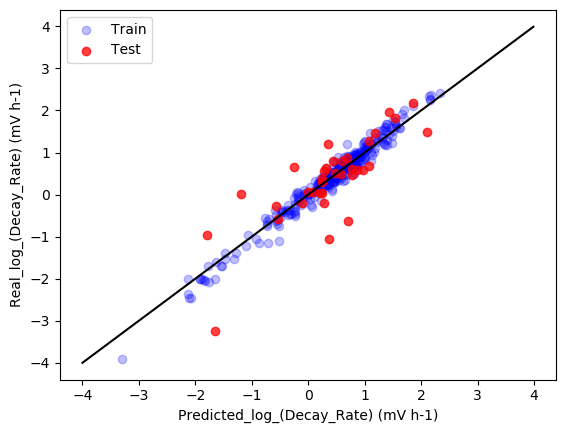

In [4]:
model_CatRegressor=catboost.CatBoostRegressor(random_state=1,verbose=0)
param_cat = {
# 'learning_rate':[0.001,0.002,0.004,0.005,0.006,0.008,0.01,0.02,0.04,0.06,0.05,0.06,0.08,0.1,0.12,0.14,0.15,0.16,0.18,0.2],
# 'n_estimators':[100,200,400],
# "boosting_type":["Plain"],
# 'max_depth':[5,7,9,11],
# 'subsample':[0.4,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1],
# 'reg_lambda':[0,0.001,0.01,0.0001,0.00001]
    'boosting_type': ['Plain'], 'learning_rate': [0.04], 'max_depth': [5], 'n_estimators': [400], 'reg_lambda': [0.001], 'subsample': [0.65]
}
CAT_full,CAT_full_score=gridsearch(model_CatRegressor,param_cat,'CatBoost',X_train,y_train,X_test,y_test)

XGBoost
Best Regressor: {'booster': 'gbtree', 'learning_rate': 0.01, 'max_depth': 13, 'n_estimators': 200, 'reg_alpha': 0.001, 'reg_lambda': 0.01, 'subsample': 0.5} Best Score: -0.40073922796082406
(0.42661685970521, 0.3550510210150363, 0.5958615787370724, 0.4197015715386049)
R2 TEST 0.4197015715386049


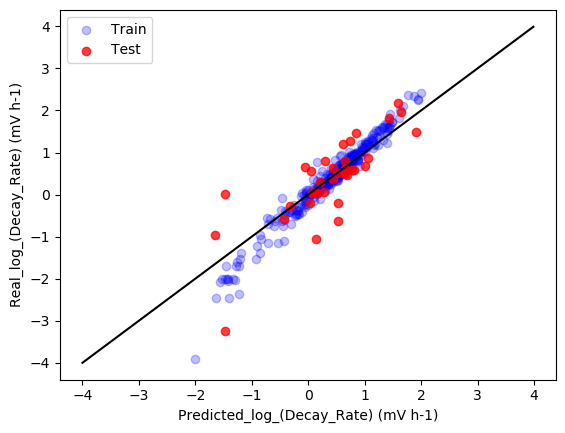

In [5]:
model_XGRegressor=XGBRegressor(random_state=1)
param_xg={
# 'booster':['gbtree'],
# 'learning_rate':[0.001,0.002,0.004,0.005,0.006,0.008,0.01,0.02,0.04,0.06,0.05,0.06,0.08,0.1,0.12,0.14,0.15,0.16,0.18,0.2,0.4,0.5,0.6,0.8,1],
# 'n_estimators':[100,200,400],
# 'max_depth':[3,5,7,9,11,13,-1],
# 'subsample':[0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1],
# 'reg_alpha':[0,0.001,0.01,0.0001,0.00001],
# 'reg_lambda':[0,0.001,0.01,0.0001,0.00001]
    'booster': ['gbtree'], 'learning_rate': [0.01], 'max_depth': [13], 'n_estimators': [200], 'reg_alpha': [0.001], 'reg_lambda': [0.01], 'subsample': [0.5]
}
XG_full,XG_full_score=gridsearch(model_XGRegressor,param_xg,'XGBoost',X_train,y_train,X_test,y_test)

D:\Anaconda\envs\pdpbox\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


Random Forest
Best Regressor: {'criterion': 'mae', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 100} Best Score: -0.3968098975616291
(0.43769302295814294, 0.3690980290760579, 0.6075343850977144, 0.3798584067034394)
R2 TEST 0.3798584067034394


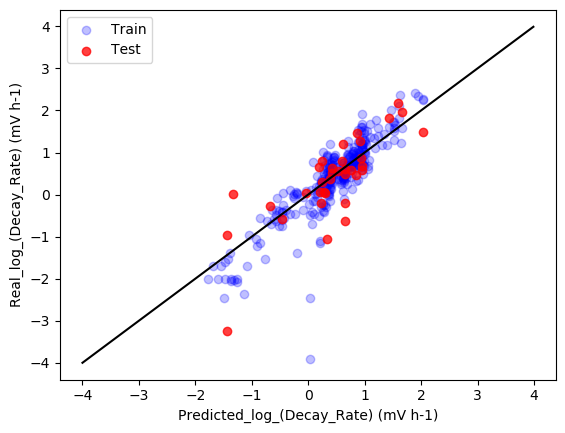

In [6]:
###########RandomForest gridsearch CV for best hyperparameter##########
model_RandomForestRegressor = ensemble.RandomForestRegressor(random_state=1)
###########defining the parameters dictionary##########
param_RF = {
# 'n_estimators':[50,100,200,400,None],
# 'max_depth':[3,5,7,9,11,None],
# 'criterion':['mse','mae'],
# 'max_features':['auto','sqrt','log2']
'criterion': ['mae'], 'max_depth': [5], 'max_features': ['auto'], 'n_estimators': [100]
}
RF_full,RF_full_score=gridsearch(model_RandomForestRegressor,param_RF,'Random Forest',X_train,y_train,X_test,y_test)

In [7]:
import math
from pdpbox.pdp_calc_utils import _calc_ice_lines_inter
from pdpbox.pdp import pdp_isolate, PDPInteract
from pdpbox.utils import (_check_model, _check_dataset, _check_percentile_range, _check_feature,
                    _check_grid_type, _check_memory_limit, _make_list,
                    _calc_memory_usage, _get_grids, _get_grid_combos, _check_classes)
from joblib import Parallel, delayed

def pdp_multi_interact(model, dataset, model_features, features, 
                    num_grid_points=None, grid_types=None, percentile_ranges=None, grid_ranges=None, cust_grid_points=None, 
                    cust_grid_combos=None, use_custom_grid_combos=False,
                    memory_limit=0.9, n_jobs=8, predict_kwds=None, data_transformer=None):

    def _expand_default(x, default, length):
        if x is None:
            return [default] * length
        return x

    def _get_grid_combos(feature_grids, feature_types):
        grids = [np.array(list(feature_grid),dtype=np.float16) for feature_grid in feature_grids]
        for i in range(len(feature_types)):
            if feature_types[i] == 'onehot':
                grids[i] = np.eye(len(grids[i])).astype(int).tolist()
        return np.stack(np.meshgrid(*grids,copy=bool), -1).reshape(-1, len(grids))

    if predict_kwds is None:
        predict_kwds = dict()

    nr_feats = len(features)

    # check function inputs
    n_classes, predict = _check_model(model=model)
    _check_dataset(df=dataset)
    _dataset = dataset.copy()

    # prepare the grid
    pdp_isolate_outs = []
    if use_custom_grid_combos:
        grid_combos = cust_grid_combos
        feature_grids = []
        feature_types = []
    else:
        num_grid_points = _expand_default(x=num_grid_points, default=10, length=nr_feats)
        grid_types = _expand_default(x=grid_types, default='percentile', length=nr_feats)
        for i in range(nr_feats):
            _check_grid_type(grid_type=grid_types[i])

        percentile_ranges = _expand_default(x=percentile_ranges, default=None, length=nr_feats)
        for i in range(nr_feats):
            _check_percentile_range(percentile_range=percentile_ranges[i])

        grid_ranges = _expand_default(x=grid_ranges, default=None, length=nr_feats)
        cust_grid_points = _expand_default(x=cust_grid_points, default=None, length=nr_feats)

        _check_memory_limit(memory_limit=memory_limit)

        pdp_isolate_outs = []
        for idx in range(nr_feats):
            pdp_isolate_out = pdp_isolate(
                model=model, dataset=_dataset, model_features=model_features, feature=features[idx],
                num_grid_points=num_grid_points[idx], grid_type=grid_types[idx], percentile_range=percentile_ranges[idx],
                grid_range=grid_ranges[idx], cust_grid_points=cust_grid_points[idx], memory_limit=memory_limit,
                n_jobs=n_jobs, predict_kwds=predict_kwds, data_transformer=data_transformer)
            pdp_isolate_outs.append(pdp_isolate_out)

        if n_classes > 2:
            feature_grids = [pdp_isolate_outs[i][0].feature_grids for i in range(nr_feats)]
            feature_types = [pdp_isolate_outs[i][0].feature_type  for i in range(nr_feats)]
        else:
            feature_grids = [pdp_isolate_outs[i].feature_grids for i in range(nr_feats)]
            feature_types = [pdp_isolate_outs[i].feature_type  for i in range(nr_feats)]

        grid_combos = _get_grid_combos(feature_grids, feature_types)

    feature_list = []
    for i in range(nr_feats):
        feature_list.extend(_make_list(features[i]))

    # Parallel calculate ICE lines
    true_n_jobs = _calc_memory_usage(
        df=_dataset, total_units=len(grid_combos), n_jobs=n_jobs, memory_limit=memory_limit)

    grid_results = Parallel(n_jobs=true_n_jobs)(delayed(_calc_ice_lines_inter)(
        grid_combo, data=_dataset, model=model, model_features=model_features, n_classes=n_classes,
        feature_list=feature_list, predict_kwds=predict_kwds, data_transformer=data_transformer)
                                                for grid_combo in grid_combos)

    ice_lines = pd.concat(grid_results, axis=0).reset_index(drop=True)
    pdp = ice_lines.groupby(feature_list, as_index=False).mean()

    # combine the final results
    pdp_interact_params = {'n_classes': n_classes, 
                        'features': features, 
                        'feature_types': feature_types,
                        'feature_grids': feature_grids}
    if n_classes > 2:
        pdp_interact_out = []
        for n_class in range(n_classes):
            _pdp = pdp[feature_list + ['class_%d_preds' % n_class]].rename(
                columns={'class_%d_preds' % n_class: 'preds'})
            pdp_interact_out.append(
                PDPInteract(which_class=n_class,
                            pdp_isolate_outs=[pdp_isolate_outs[i][n_class] for i in range(nr_feats)],
                            pdp=_pdp, **pdp_interact_params))
    else:
        pdp_interact_out = PDPInteract(
            which_class=None, pdp_isolate_outs=pdp_isolate_outs, pdp=pdp, **pdp_interact_params)

    return pdp_interact_out
print('ready')

ready


In [8]:
def center(arr): return arr - np.mean(arr)
import itertools
def compute_f_vals(mdl, X, features, selectedfeatures, num_grid_points=10, use_data_grid=False):
    f_vals = {}
    data_grid = None
    if use_data_grid:
        data_grid = X[selectedfeatures].values
    # Calculate partial dependencies for full feature set
    p_full = pdp_multi_interact(mdl, X, features, selectedfeatures, 
                                num_grid_points=[num_grid_points] * len(selectedfeatures),
                                cust_grid_combos=data_grid,
                                use_custom_grid_combos=use_data_grid)
    f_vals[tuple(selectedfeatures)] = center(p_full.pdp.preds.values)
    grid = p_full.pdp.drop('preds', axis=1)
    # Calculate partial dependencies for [1..SFL-1]
    for n in range(1, len(selectedfeatures)):
        for subsetfeatures in itertools.combinations(selectedfeatures, n):
            if use_data_grid:
                data_grid = X[list(subsetfeatures)].values
            p_partial = pdp_multi_interact(mdl, X, features, subsetfeatures, 
                                        num_grid_points=[num_grid_points] * len(selectedfeatures),
                                        cust_grid_combos=data_grid,
                                        use_custom_grid_combos=use_data_grid)
            p_joined = pd.merge(grid, p_partial.pdp, how='left')
            f_vals[tuple(subsetfeatures)] = center(p_joined.preds.values)
    return f_vals
def compute_h_val(f_vals, selectedfeatures):
    denom_els = f_vals[tuple(selectedfeatures)].copy()
    numer_els = f_vals[tuple(selectedfeatures)].copy()
    sign = -1.0
    for n in range(len(selectedfeatures)-1, 0, -1):
        for subfeatures in itertools.combinations(selectedfeatures, n):
            print(tuple(subfeatures))
            numer_els += sign * f_vals[tuple(subfeatures)]
        sign *= -1.0
    numer = np.sum(numer_els**2)
    denom = np.sum(denom_els**2)
    return math.sqrt(numer/denom) if numer < denom else np.nan
def compute_h_val_any(f_vals, allfeatures, selectedfeature):
    otherfeatures = list(allfeatures)
    otherfeatures.remove(selectedfeature)
    denom_els = f_vals[tuple(allfeatures)].copy()
    numer_els = denom_els.copy()
    numer_els -= f_vals[(selectedfeature,)]
    numer_els -= f_vals[tuple(otherfeatures)]
    numer = np.sum(numer_els**2)
    denom = np.sum(denom_els**2)
    return math.sqrt(numer/denom) if numer < denom else np.nan
def compute_interactions(model,X_train,feature_all,feature_select_list):  
    result_dict={}
    for i in range(len(feature_select_list)):
        for j in range(len(feature_select_list)):
            if i<j :
                print(i,j)
                try:
                    current_features=[feature_select_list[i],feature_select_list[j]]
                    f_vals=compute_f_vals(model, X_train, feature_all,current_features) 
                    result_dict[tuple(current_features)]=compute_h_val(f_vals,current_features)
                except:
                    result_dict[tuple(current_features)]=0
                print(result_dict[tuple(current_features)])
    return result_dict

In [9]:
CAT_DICT=compute_interactions(CAT_full,data_input_full,data_input_full.columns,list(data_input_full.columns))

0 1
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Atomic Number',)
0.10947584145813488
0 2
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Period',)
1.1196158780193742e-15
0 3
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Group',)
0.13985092732478985
0 4
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Ionization Potential',)
0.030280567608866014
0 5
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Electronegativity',)
0.03574203837766571
0 6
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Number of d electrons',)
0.04542747724056201
0 7
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Atomic Radius',)
0.09991681918010174
0 8
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_2 Relative Atomic Mass',)
0.050479210058500555
0 9
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_2 Atomic Number',)
0.1298618448082882
0 10
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_2 Period',)
0.021811893735167964


('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_4 Number of d electrons',)
6.052141617646328e-16
1 31
('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_4 Atomic Radius',)
6.88894603830638e-16
1 32
('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_1 Proportion in Precursor ',)
0.0054525990635435895
1 33
('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.09943305384667205
1 34
('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.03553748380622815
1 35
('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_4 Proportion in Precursor ',)
0.010905123721784545
1 36
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Temperature (Celcius degree)',)
0.08592902771033843
1 37
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Time (min)',)
0.14952508896605096
1 38
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Still/Strring (0/1)',)
0.08856482949145952
1 39
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
6.607777

('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Relative Atomic Mass',)
4.073820991277693e-15
3 17
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Atomic Number',)
0.1472587738519083
3 18
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Period',)
2.3515505724993214e-14
3 19
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Group',)
0.07618515092711166
3 20
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Ionization Potential',)
0.008372101100047064
3 21
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Electronegativity',)
0.06604477410040739
3 22
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Number of d electrons',)
0.027050980369746725
3 23
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Atomic Radius',)
0.006759693502228053
3 24
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Relative Atomic Mass',)
6.740191384258665e-15
3 25
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Atomic Number',)
9.531681086344117e-15
3 26
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Period',)
3.5455208125150176e-14
3 27
('Metal_Dopant_1 Group',)
('Metal_Dopant

('Metal_Dopant_1 Ionization Potential',)
('Support is not Carbon (0/1)',)
0.0
4 51
('Metal_Dopant_1 Ionization Potential',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
4.609474348591575e-15
4 52
('Metal_Dopant_1 Ionization Potential',)
('Electrolyte Proton Concentration (M)',)
0.08114003137576263
4 53
('Metal_Dopant_1 Ionization Potential',)
('Stability Current Density (mA cm-2)',)
0.04919583036572775
4 54
('Metal_Dopant_1 Ionization Potential',)
('Stability Test Time (h)',)
0.015029718579736942
5 6
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_1 Number of d electrons',)
0.0401708253737016
5 7
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_1 Atomic Radius',)
0.00207385190470251
5 8
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Relative Atomic Mass',)
0.17956289150885868
5 9
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Atomic Number',)
0.0323041245617718
5 10
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Period',)
7.1518520388

('Metal_Dopant_1 Number of d electrons',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.020411316528632328
6 35
('Metal_Dopant_1 Number of d electrons',)
('Metal_Dopant_4 Proportion in Precursor ',)
0.0402576749417413
6 36
('Metal_Dopant_1 Number of d electrons',)
('Hydrothermal Temperature (Celcius degree)',)
0.25678906977251653
6 37
('Metal_Dopant_1 Number of d electrons',)
('Hydrothermal Time (min)',)
0.04685178283852089
6 38
('Metal_Dopant_1 Number of d electrons',)
('Hydrothermal Still/Strring (0/1)',)
0.05393799501794952
6 39
('Metal_Dopant_1 Number of d electrons',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
0.016875365543030926
6 40
('Metal_Dopant_1 Number of d electrons',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
2.0695261272019023e-15
6 41
('Metal_Dopant_1 Number of d electrons',)
('Mixed in Solid or Liquid (0/1)',)
0.04266073578697846
6 42
('Metal_Dopant_1 Number of d electrons',)
('Annealing Temperature (Celcius Degree)',)
0.2353414311070053
6 43
('Metal_Do

('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_3 Atomic Radius',)
0.028370718601531553
8 24
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Relative Atomic Mass',)
2.223241042605326e-15
8 25
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Atomic Number',)
3.1875039541452182e-15
8 26
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Period',)
0.08067678097240277
8 27
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Group',)
2.488111366549107e-15
8 28
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Ionization Potential',)
2.1544560238641533e-15
8 29
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Electronegativity',)
4.693474387072737e-15
8 30
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Number of d electrons',)
1.1705533486555874e-15
8 31
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Atomic Radius',)
1.4749758792319689e-15
8 32
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_1 Proportion i

('Metal_Dopant_2 Period',)
('Metal_Dopant_3 Relative Atomic Mass',)
5.144352624671666e-15
10 17
('Metal_Dopant_2 Period',)
('Metal_Dopant_3 Atomic Number',)
4.132784131473238e-15
10 18
('Metal_Dopant_2 Period',)
('Metal_Dopant_3 Period',)
0.08315453962559731
10 19
('Metal_Dopant_2 Period',)
('Metal_Dopant_3 Group',)
0.028550742005549086
10 20
('Metal_Dopant_2 Period',)
('Metal_Dopant_3 Ionization Potential',)
5.96334427926347e-15
10 21
('Metal_Dopant_2 Period',)
('Metal_Dopant_3 Electronegativity',)
3.474897901110829e-15
10 22
('Metal_Dopant_2 Period',)
('Metal_Dopant_3 Number of d electrons',)
0.03906166449194557
10 23
('Metal_Dopant_2 Period',)
('Metal_Dopant_3 Atomic Radius',)
0.024361433055005707
10 24
('Metal_Dopant_2 Period',)
('Metal_Dopant_4 Relative Atomic Mass',)
1.2905348137576533e-14
10 25
('Metal_Dopant_2 Period',)
('Metal_Dopant_4 Atomic Number',)
0.16558783990867992
10 26
('Metal_Dopant_2 Period',)
('Metal_Dopant_4 Period',)
1.822980693320058e-14
10 27
('Metal_Dopant_2 P

('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_3 Ionization Potential',)
0.08020051066486429
12 21
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_3 Electronegativity',)
0.017095949552915338
12 22
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_3 Number of d electrons',)
0.4688714657645291
12 23
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_3 Atomic Radius',)
0.06831175140337611
12 24
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_4 Relative Atomic Mass',)
5.879082885118117e-15
12 25
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_4 Atomic Number',)
3.781806876821402e-15
12 26
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_4 Period',)
1.0915535622317249e-15
12 27
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_4 Group',)
0.0804351547352477
12 28
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_4 Ionization Potential',)
5.3921434905098166e-15
12 29
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_4 Electr

('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_3 Period',)
0.32018259497968493
14 19
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_3 Group',)
0.49468281376117157
14 20
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_3 Ionization Potential',)
4.029835720168584e-15
14 21
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_3 Electronegativity',)
0.17413327165438422
14 22
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_3 Number of d electrons',)
4.747000976102365e-15
14 23
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_3 Atomic Radius',)
0.027022281105141547
14 24
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_4 Relative Atomic Mass',)
2.1608050640139353e-14
14 25
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_4 Atomic Number',)
1.8076426142452594e-14
14 26
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_4 Period',)
2.1517373627894717e-14
14 27
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_4 Group

('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_3 Electronegativity',)
2.643845245247747e-15
16 22
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_3 Number of d electrons',)
0.039963071672024016
16 23
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_3 Atomic Radius',)
7.062701896707093e-16
16 24
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_4 Relative Atomic Mass',)
2.405415970096225e-15
16 25
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_4 Atomic Number',)
3.803274000892711e-15
16 26
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_4 Period',)
4.49917950216275e-15
16 27
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_4 Group',)
0.2862952735569399
16 28
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_4 Ionization Potential',)
5.288490881106491e-15
16 29
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_4 Electronegativity',)
5.7890504147650705e-15
16 30
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_4 Numb

('Metal_Dopant_3 Period',)
('Metal_Dopant_4 Electronegativity',)
1.194505477174704e-14
18 30
('Metal_Dopant_3 Period',)
('Metal_Dopant_4 Number of d electrons',)
0.2389328725034429
18 31
('Metal_Dopant_3 Period',)
('Metal_Dopant_4 Atomic Radius',)
7.332921162805058e-15
18 32
('Metal_Dopant_3 Period',)
('Metal_Dopant_1 Proportion in Precursor ',)
0.08058156706292373
18 33
('Metal_Dopant_3 Period',)
('Metal_Dopant_2 Proportion in Precursor ',)
4.885507851696413e-15
18 34
('Metal_Dopant_3 Period',)
('Metal_Dopant_3 Proportion in Precursor ',)
4.98859107057186e-15
18 35
('Metal_Dopant_3 Period',)
('Metal_Dopant_4 Proportion in Precursor ',)
2.121927083543408e-14
18 36
('Metal_Dopant_3 Period',)
('Hydrothermal Temperature (Celcius degree)',)
0.03240618737300464
18 37
('Metal_Dopant_3 Period',)
('Hydrothermal Time (min)',)
0.026838325149607316
18 38
('Metal_Dopant_3 Period',)
('Hydrothermal Still/Strring (0/1)',)
3.876995638029132e-15
18 39
('Metal_Dopant_3 Period',)
('Hydrothermal Strong Re

('Metal_Dopant_3 Ionization Potential',)
('Annealing Atomosphere Reductive (0/1)',)
0.05695827239688807
20 47
('Metal_Dopant_3 Ionization Potential',)
('Post-processing Acid Wash etc. (0/1)',)
2.944750829703517e-15
20 48
('Metal_Dopant_3 Ionization Potential',)
('Catalyst Loading (mg cm -2)',)
0.008676468627070557
20 49
('Metal_Dopant_3 Ionization Potential',)
('Support Material Loading (mg cm -2)',)
0.012234020621664038
20 50
('Metal_Dopant_3 Ionization Potential',)
('Support is not Carbon (0/1)',)
0.0
20 51
('Metal_Dopant_3 Ionization Potential',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
4.4294102724882955e-15
20 52
('Metal_Dopant_3 Ionization Potential',)
('Electrolyte Proton Concentration (M)',)
0.06192305723588558
20 53
('Metal_Dopant_3 Ionization Potential',)
('Stability Current Density (mA cm-2)',)
0.013100457995478454
20 54
('Metal_Dopant_3 Ionization Potential',)
('Stability Test Time (h)',)
0.02738574087586039
21 22
('Metal_Dopant_3 Electronegativity',)

('Metal_Dopant_3 Atomic Radius',)
('Metal_Dopant_4 Ionization Potential',)
0.06586243301819614
23 29
('Metal_Dopant_3 Atomic Radius',)
('Metal_Dopant_4 Electronegativity',)
8.937104088304938e-16
23 30
('Metal_Dopant_3 Atomic Radius',)
('Metal_Dopant_4 Number of d electrons',)
0.0416468285471309
23 31
('Metal_Dopant_3 Atomic Radius',)
('Metal_Dopant_4 Atomic Radius',)
5.164289641725554e-16
23 32
('Metal_Dopant_3 Atomic Radius',)
('Metal_Dopant_1 Proportion in Precursor ',)
0.027567334175758382
23 33
('Metal_Dopant_3 Atomic Radius',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.02409121652181802
23 34
('Metal_Dopant_3 Atomic Radius',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.004899035646016736
23 35
('Metal_Dopant_3 Atomic Radius',)
('Metal_Dopant_4 Proportion in Precursor ',)
4.91725748974303e-16
23 36
('Metal_Dopant_3 Atomic Radius',)
('Hydrothermal Temperature (Celcius degree)',)
0.01118904210613246
23 37
('Metal_Dopant_3 Atomic Radius',)
('Hydrothermal Time (min)',)
0.0661604

('Metal_Dopant_4 Atomic Number',)
('Support is not Carbon (0/1)',)
0.0
25 51
('Metal_Dopant_4 Atomic Number',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
6.303795020398276e-14
25 52
('Metal_Dopant_4 Atomic Number',)
('Electrolyte Proton Concentration (M)',)
5.084726147795122e-15
25 53
('Metal_Dopant_4 Atomic Number',)
('Stability Current Density (mA cm-2)',)
0.05720593547242924
25 54
('Metal_Dopant_4 Atomic Number',)
('Stability Test Time (h)',)
0.008720358291892168
26 27
('Metal_Dopant_4 Period',)
('Metal_Dopant_4 Group',)
1.3767623030969283e-14
26 28
('Metal_Dopant_4 Period',)
('Metal_Dopant_4 Ionization Potential',)
3.156632071180906e-14
26 29
('Metal_Dopant_4 Period',)
('Metal_Dopant_4 Electronegativity',)
1.0523383496989246e-14
26 30
('Metal_Dopant_4 Period',)
('Metal_Dopant_4 Number of d electrons',)
3.0104249470722886e-14
26 31
('Metal_Dopant_4 Period',)
('Metal_Dopant_4 Atomic Radius',)
3.95321706662713e-14
26 32
('Metal_Dopant_4 Period',)
('Metal_Dopant_1 

('Metal_Dopant_4 Ionization Potential',)
('Stability Current Density (mA cm-2)',)
1.542074172871007e-15
28 54
('Metal_Dopant_4 Ionization Potential',)
('Stability Test Time (h)',)
0.024226527547207485
29 30
('Metal_Dopant_4 Electronegativity',)
('Metal_Dopant_4 Number of d electrons',)
1.0235862036850315e-14
29 31
('Metal_Dopant_4 Electronegativity',)
('Metal_Dopant_4 Atomic Radius',)
8.057440772635584e-15
29 32
('Metal_Dopant_4 Electronegativity',)
('Metal_Dopant_1 Proportion in Precursor ',)
0.13363613321356954
29 33
('Metal_Dopant_4 Electronegativity',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.029942344418333183
29 34
('Metal_Dopant_4 Electronegativity',)
('Metal_Dopant_3 Proportion in Precursor ',)
9.557560829984508e-15
29 35
('Metal_Dopant_4 Electronegativity',)
('Metal_Dopant_4 Proportion in Precursor ',)
9.986514164919176e-15
29 36
('Metal_Dopant_4 Electronegativity',)
('Hydrothermal Temperature (Celcius degree)',)
0.0807124645164299
29 37
('Metal_Dopant_4 Electronegativit

('Metal_Dopant_1 Proportion in Precursor ',)
('Hydrothermal Time (min)',)
0.17731501285515788
32 38
('Metal_Dopant_1 Proportion in Precursor ',)
('Hydrothermal Still/Strring (0/1)',)
0.1346810608200671
32 39
('Metal_Dopant_1 Proportion in Precursor ',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
0.045847214154444406
32 40
('Metal_Dopant_1 Proportion in Precursor ',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
4.4636710291414125e-15
32 41
('Metal_Dopant_1 Proportion in Precursor ',)
('Mixed in Solid or Liquid (0/1)',)
0.05744772696542682
32 42
('Metal_Dopant_1 Proportion in Precursor ',)
('Annealing Temperature (Celcius Degree)',)
0.06382150885447081
32 43
('Metal_Dopant_1 Proportion in Precursor ',)
('Annealing Time (min)',)
0.12352672558135062
32 44
('Metal_Dopant_1 Proportion in Precursor ',)
('Annealing Still/Strring (0/1)',)
0.0
32 45
('Metal_Dopant_1 Proportion in Precursor ',)
('Annealing Atomosphere Inert (0/1)',)
0.00510744637259521
32 46
('Metal_Dopant_1 Proportion

('Metal_Dopant_4 Proportion in Precursor ',)
('Electrolyte Proton Concentration (M)',)
0.39093425554221184
35 53
('Metal_Dopant_4 Proportion in Precursor ',)
('Stability Current Density (mA cm-2)',)
0.10379096377310508
35 54
('Metal_Dopant_4 Proportion in Precursor ',)
('Stability Test Time (h)',)
0.023850216178485165
36 37
('Hydrothermal Temperature (Celcius degree)',)
('Hydrothermal Time (min)',)
0.20717946250232996
36 38
('Hydrothermal Temperature (Celcius degree)',)
('Hydrothermal Still/Strring (0/1)',)
0.5092584007780795
36 39
('Hydrothermal Temperature (Celcius degree)',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
1.8362357019858935e-15
36 40
('Hydrothermal Temperature (Celcius degree)',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
0.3043188522993203
36 41
('Hydrothermal Temperature (Celcius degree)',)
('Mixed in Solid or Liquid (0/1)',)
1.4030230994056648e-15
36 42
('Hydrothermal Temperature (Celcius degree)',)
('Annealing Temperature (Celcius Degree)',)
0.072677150

('Hydrothermal Weak Reductant in Liquid (0/1)',)
('Support Material Loading (mg cm -2)',)
1.2595270659523787e-15
40 50
('Hydrothermal Weak Reductant in Liquid (0/1)',)
('Support is not Carbon (0/1)',)
0.0
40 51
('Hydrothermal Weak Reductant in Liquid (0/1)',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
0.8714342580851567
40 52
('Hydrothermal Weak Reductant in Liquid (0/1)',)
('Electrolyte Proton Concentration (M)',)
0.07991396855340643
40 53
('Hydrothermal Weak Reductant in Liquid (0/1)',)
('Stability Current Density (mA cm-2)',)
0.003662190965315418
40 54
('Hydrothermal Weak Reductant in Liquid (0/1)',)
('Stability Test Time (h)',)
2.0451346940525988e-16
41 42
('Mixed in Solid or Liquid (0/1)',)
('Annealing Temperature (Celcius Degree)',)
0.10832453917565506
41 43
('Mixed in Solid or Liquid (0/1)',)
('Annealing Time (min)',)
0.0646531612998342
41 44
('Mixed in Solid or Liquid (0/1)',)
('Annealing Still/Strring (0/1)',)
0.0
41 45
('Mixed in Solid or Liquid (0/1)',)


('Catalyst Loading (mg cm -2)',)
('Stability Test Time (h)',)
0.022405642144413374
49 50
('Support Material Loading (mg cm -2)',)
('Support is not Carbon (0/1)',)
8.407702203847317e-16
49 51
('Support Material Loading (mg cm -2)',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
9.015457703966203e-16
49 52
('Support Material Loading (mg cm -2)',)
('Electrolyte Proton Concentration (M)',)
0.013181247439647166
49 53
('Support Material Loading (mg cm -2)',)
('Stability Current Density (mA cm-2)',)
0.21222181430932693
49 54
('Support Material Loading (mg cm -2)',)
('Stability Test Time (h)',)
0.028144852344489876
50 51
('Support is not Carbon (0/1)',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
0.0
50 52
('Support is not Carbon (0/1)',)
('Electrolyte Proton Concentration (M)',)
0.0
50 53
('Support is not Carbon (0/1)',)
('Stability Current Density (mA cm-2)',)
0.0
50 54
('Support is not Carbon (0/1)',)
('Stability Test Time (h)',)
6.822446430564154e-17
5

In [10]:
XG_DICT=compute_interactions(XG_full,data_input_full,data_input_full.columns,list(data_input_full.columns))

0 1
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Atomic Number',)
0.0008714636101572338
0 2
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Period',)
0.0010279310795574387
0 3
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Group',)
0.011770633369150553
0 4
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Ionization Potential',)
0.009832722781005738
0 5
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Electronegativity',)
0.005277706906741403
0 6
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Number of d electrons',)
0.13034048685558905
0 7
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Atomic Radius',)
0.014488428123392532
0 8
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_2 Relative Atomic Mass',)
0.05133015817305245
0 9
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_2 Atomic Number',)
0.002822398293519703
0 10
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_2 Period',)
0.0
0 11
('Metal

('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.0029769186290515186
1 34
('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.06127188170353677
1 35
('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_4 Proportion in Precursor ',)
0.0
1 36
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Temperature (Celcius degree)',)
0.001207120965243308
1 37
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Time (min)',)
0.0033968516348694172
1 38
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Still/Strring (0/1)',)
0.05060337163892981
1 39
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
0.0187537842647063
1 40
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
3.8350046889986296e-05
1 41
('Metal_Dopant_1 Atomic Number',)
('Mixed in Solid or Liquid (0/1)',)
2.8751744005630252e-06
1 42
('Metal_Dopant_1 Atomic Number',)
('Annealing Temperature (Celcius Degree)',)
0.0049619851

('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Group',)
0.026974482600512387
3 20
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Ionization Potential',)
0.03277303019101153
3 21
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Electronegativity',)
0.03144160961182987
3 22
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Number of d electrons',)
0.013114265105525059
3 23
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Atomic Radius',)
0.00524504713329699
3 24
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Relative Atomic Mass',)
0.008931458086862297
3 25
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Atomic Number',)
6.1511895380106926e-06
3 26
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Period',)
6.1511895380106926e-06
3 27
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Group',)
6.1511895380106926e-06
3 28
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Ionization Potential',)
6.1511895380106926e-06
3 29
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Electronegativity',)
6.1511895380106926e-06
3 30
('Metal_Dopant_1 Group',)
('Metal

('Metal_Dopant_1 Ionization Potential',)
('Stability Test Time (h)',)
0.011508674858725905
5 6
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_1 Number of d electrons',)
0.016426818165158837
5 7
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_1 Atomic Radius',)
0.02698365526214143
5 8
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Relative Atomic Mass',)
0.060118060406202815
5 9
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Atomic Number',)
0.027472559843771532
5 10
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Period',)
0.0
5 11
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Group',)
0.011954063448032211
5 12
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Ionization Potential',)
0.048790256597873435
5 13
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Electronegativity',)
0.021238411901927053
5 14
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Number of d electrons',)
0.07555200150107264
5 15
('Metal_Dopant_1 Electrone

('Metal_Dopant_1 Number of d electrons',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
0.0017134765594564129
6 40
('Metal_Dopant_1 Number of d electrons',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
0.001797784920896421
6 41
('Metal_Dopant_1 Number of d electrons',)
('Mixed in Solid or Liquid (0/1)',)
0.010300022049008515
6 42
('Metal_Dopant_1 Number of d electrons',)
('Annealing Temperature (Celcius Degree)',)
0.14052390067181716
6 43
('Metal_Dopant_1 Number of d electrons',)
('Annealing Time (min)',)
0.0243558523504277
6 44
('Metal_Dopant_1 Number of d electrons',)
('Annealing Still/Strring (0/1)',)
0.004754329413944761
6 45
('Metal_Dopant_1 Number of d electrons',)
('Annealing Atomosphere Inert (0/1)',)
0.0033929851848701546
6 46
('Metal_Dopant_1 Number of d electrons',)
('Annealing Atomosphere Reductive (0/1)',)
0.1109035241793548
6 47
('Metal_Dopant_1 Number of d electrons',)
('Post-processing Acid Wash etc. (0/1)',)
0.011754394626367851
6 48
('Metal_Dopant_1 Number of

('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Electronegativity',)
2.5385288359272826e-06
8 30
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Number of d electrons',)
2.5385288359272826e-06
8 31
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Atomic Radius',)
2.5385288359272826e-06
8 32
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_1 Proportion in Precursor ',)
0.051647644835485576
8 33
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.08167209509230026
8 34
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.030976792475362613
8 35
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Proportion in Precursor ',)
2.5385288359272826e-06
8 36
('Metal_Dopant_2 Relative Atomic Mass',)
('Hydrothermal Temperature (Celcius degree)',)
0.08146051132399444
8 37
('Metal_Dopant_2 Relative Atomic Mass',)
('Hydrothermal Time (min)',)
0.23302831791376855
8 38
('Metal_Dopant_2 Relat

('Metal_Dopant_2 Period',)
('Metal_Dopant_4 Atomic Number',)
nan
10 26
('Metal_Dopant_2 Period',)
('Metal_Dopant_4 Period',)
nan
10 27
('Metal_Dopant_2 Period',)
('Metal_Dopant_4 Group',)
nan
10 28
('Metal_Dopant_2 Period',)
('Metal_Dopant_4 Ionization Potential',)
nan
10 29
('Metal_Dopant_2 Period',)
('Metal_Dopant_4 Electronegativity',)
nan
10 30
('Metal_Dopant_2 Period',)
('Metal_Dopant_4 Number of d electrons',)
nan
10 31
('Metal_Dopant_2 Period',)
('Metal_Dopant_4 Atomic Radius',)
nan
10 32
('Metal_Dopant_2 Period',)
('Metal_Dopant_1 Proportion in Precursor ',)
0.0
10 33
('Metal_Dopant_2 Period',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.0
10 34
('Metal_Dopant_2 Period',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.0
10 35
('Metal_Dopant_2 Period',)
('Metal_Dopant_4 Proportion in Precursor ',)
nan
10 36
('Metal_Dopant_2 Period',)
('Hydrothermal Temperature (Celcius degree)',)
0.0
10 37
('Metal_Dopant_2 Period',)
('Hydrothermal Time (min)',)
0.0
10 38
('Metal_Dopant_2 Peri

('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_1 Proportion in Precursor ',)
0.02774730971758741
12 33
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.07764550825063675
12 34
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.014328118202956396
12 35
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_4 Proportion in Precursor ',)
3.1941815967908844e-06
12 36
('Metal_Dopant_2 Ionization Potential',)
('Hydrothermal Temperature (Celcius degree)',)
0.04157068826211293
12 37
('Metal_Dopant_2 Ionization Potential',)
('Hydrothermal Time (min)',)
0.031319808474429514
12 38
('Metal_Dopant_2 Ionization Potential',)
('Hydrothermal Still/Strring (0/1)',)
0.07408623409644308
12 39
('Metal_Dopant_2 Ionization Potential',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
0.04800602011364824
12 40
('Metal_Dopant_2 Ionization Potential',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
0.020436854588026795
12 

('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_4 Number of d electrons',)
0.0
14 31
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_4 Atomic Radius',)
0.0
14 32
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_1 Proportion in Precursor ',)
0.08896997292531977
14 33
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.10862130803406617
14 34
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.03951855070312218
14 35
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_4 Proportion in Precursor ',)
0.0
14 36
('Metal_Dopant_2 Number of d electrons',)
('Hydrothermal Temperature (Celcius degree)',)
0.025974143424725052
14 37
('Metal_Dopant_2 Number of d electrons',)
('Hydrothermal Time (min)',)
0.006066520149760773
14 38
('Metal_Dopant_2 Number of d electrons',)
('Hydrothermal Still/Strring (0/1)',)
0.03392201091940317
14 39
('Metal_Dopant_2 Number of d electrons',)
('Hydrothermal Strong 

('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_4 Proportion in Precursor ',)
0.0
16 36
('Metal_Dopant_3 Relative Atomic Mass',)
('Hydrothermal Temperature (Celcius degree)',)
0.02528338411803457
16 37
('Metal_Dopant_3 Relative Atomic Mass',)
('Hydrothermal Time (min)',)
0.03327831876913549
16 38
('Metal_Dopant_3 Relative Atomic Mass',)
('Hydrothermal Still/Strring (0/1)',)
0.0633456898419529
16 39
('Metal_Dopant_3 Relative Atomic Mass',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
0.020422635130774483
16 40
('Metal_Dopant_3 Relative Atomic Mass',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
0.00506153585017793
16 41
('Metal_Dopant_3 Relative Atomic Mass',)
('Mixed in Solid or Liquid (0/1)',)
0.015815338299090636
16 42
('Metal_Dopant_3 Relative Atomic Mass',)
('Annealing Temperature (Celcius Degree)',)
0.02839065009633269
16 43
('Metal_Dopant_3 Relative Atomic Mass',)
('Annealing Time (min)',)
0.02497491360204089
16 44
('Metal_Dopant_3 Relative Atomic Mass',)
('Anne

('Metal_Dopant_3 Period',)
('Electrolyte Proton Concentration (M)',)
0.0019170322172183765
18 53
('Metal_Dopant_3 Period',)
('Stability Current Density (mA cm-2)',)
9.988755903017327e-07
18 54
('Metal_Dopant_3 Period',)
('Stability Test Time (h)',)
0.0002243206294913531
19 20
('Metal_Dopant_3 Group',)
('Metal_Dopant_3 Ionization Potential',)
0.0007117352471777632
19 21
('Metal_Dopant_3 Group',)
('Metal_Dopant_3 Electronegativity',)
4.053488827392046e-06
19 22
('Metal_Dopant_3 Group',)
('Metal_Dopant_3 Number of d electrons',)
0.024352448917871753
19 23
('Metal_Dopant_3 Group',)
('Metal_Dopant_3 Atomic Radius',)
0.010308376104854168
19 24
('Metal_Dopant_3 Group',)
('Metal_Dopant_4 Relative Atomic Mass',)
0.03908150776698859
19 25
('Metal_Dopant_3 Group',)
('Metal_Dopant_4 Atomic Number',)
0.0
19 26
('Metal_Dopant_3 Group',)
('Metal_Dopant_4 Period',)
0.0
19 27
('Metal_Dopant_3 Group',)
('Metal_Dopant_4 Group',)
0.0
19 28
('Metal_Dopant_3 Group',)
('Metal_Dopant_4 Ionization Potential',)

('Metal_Dopant_3 Electronegativity',)
('Hydrothermal Temperature (Celcius degree)',)
0.010488822815807992
21 37
('Metal_Dopant_3 Electronegativity',)
('Hydrothermal Time (min)',)
0.008120146085128012
21 38
('Metal_Dopant_3 Electronegativity',)
('Hydrothermal Still/Strring (0/1)',)
0.019655146869343457
21 39
('Metal_Dopant_3 Electronegativity',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
5.61515133407944e-06
21 40
('Metal_Dopant_3 Electronegativity',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
3.30715268416102e-05
21 41
('Metal_Dopant_3 Electronegativity',)
('Mixed in Solid or Liquid (0/1)',)
0.03567081455656658
21 42
('Metal_Dopant_3 Electronegativity',)
('Annealing Temperature (Celcius Degree)',)
0.004296393504651145
21 43
('Metal_Dopant_3 Electronegativity',)
('Annealing Time (min)',)
0.0035946887135213327
21 44
('Metal_Dopant_3 Electronegativity',)
('Annealing Still/Strring (0/1)',)
2.6051206232020195e-05
21 45
('Metal_Dopant_3 Electronegativity',)
('Annealing Atomosph

('Metal_Dopant_3 Atomic Radius',)
('Stability Test Time (h)',)
0.11106192401195658
24 25
('Metal_Dopant_4 Relative Atomic Mass',)
('Metal_Dopant_4 Atomic Number',)
0.0
24 26
('Metal_Dopant_4 Relative Atomic Mass',)
('Metal_Dopant_4 Period',)
0.0
24 27
('Metal_Dopant_4 Relative Atomic Mass',)
('Metal_Dopant_4 Group',)
0.0
24 28
('Metal_Dopant_4 Relative Atomic Mass',)
('Metal_Dopant_4 Ionization Potential',)
0.0
24 29
('Metal_Dopant_4 Relative Atomic Mass',)
('Metal_Dopant_4 Electronegativity',)
0.0
24 30
('Metal_Dopant_4 Relative Atomic Mass',)
('Metal_Dopant_4 Number of d electrons',)
0.0
24 31
('Metal_Dopant_4 Relative Atomic Mass',)
('Metal_Dopant_4 Atomic Radius',)
0.0
24 32
('Metal_Dopant_4 Relative Atomic Mass',)
('Metal_Dopant_1 Proportion in Precursor ',)
0.005543681813516751
24 33
('Metal_Dopant_4 Relative Atomic Mass',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.0019865472095627443
24 34
('Metal_Dopant_4 Relative Atomic Mass',)
('Metal_Dopant_3 Proportion in Precursor ',)

('Metal_Dopant_4 Group',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.0
27 35
('Metal_Dopant_4 Group',)
('Metal_Dopant_4 Proportion in Precursor ',)
nan
27 36
('Metal_Dopant_4 Group',)
('Hydrothermal Temperature (Celcius degree)',)
0.0
27 37
('Metal_Dopant_4 Group',)
('Hydrothermal Time (min)',)
0.0
27 38
('Metal_Dopant_4 Group',)
('Hydrothermal Still/Strring (0/1)',)
0.0
27 39
('Metal_Dopant_4 Group',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
0.0
27 40
('Metal_Dopant_4 Group',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
0.0
27 41
('Metal_Dopant_4 Group',)
('Mixed in Solid or Liquid (0/1)',)
0.0
27 42
('Metal_Dopant_4 Group',)
('Annealing Temperature (Celcius Degree)',)
0.0
27 43
('Metal_Dopant_4 Group',)
('Annealing Time (min)',)
1.120772330221248e-06
27 44
('Metal_Dopant_4 Group',)
('Annealing Still/Strring (0/1)',)
0.0
27 45
('Metal_Dopant_4 Group',)
('Annealing Atomosphere Inert (0/1)',)
0.0
27 46
('Metal_Dopant_4 Group',)
('Annealing Atomosphere Reductive (0/1)'

('Metal_Dopant_4 Number of d electrons',)
('Electrolyte Proton Concentration (M)',)
0.0
30 53
('Metal_Dopant_4 Number of d electrons',)
('Stability Current Density (mA cm-2)',)
0.0
30 54
('Metal_Dopant_4 Number of d electrons',)
('Stability Test Time (h)',)
0.0
31 32
('Metal_Dopant_4 Atomic Radius',)
('Metal_Dopant_1 Proportion in Precursor ',)
0.0
31 33
('Metal_Dopant_4 Atomic Radius',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.0
31 34
('Metal_Dopant_4 Atomic Radius',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.0
31 35
('Metal_Dopant_4 Atomic Radius',)
('Metal_Dopant_4 Proportion in Precursor ',)
nan
31 36
('Metal_Dopant_4 Atomic Radius',)
('Hydrothermal Temperature (Celcius degree)',)
0.0
31 37
('Metal_Dopant_4 Atomic Radius',)
('Hydrothermal Time (min)',)
0.0
31 38
('Metal_Dopant_4 Atomic Radius',)
('Hydrothermal Still/Strring (0/1)',)
0.0
31 39
('Metal_Dopant_4 Atomic Radius',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
0.0
31 40
('Metal_Dopant_4 Atomic Radius',)
(

('Metal_Dopant_3 Proportion in Precursor ',)
('Annealing Atomosphere Reductive (0/1)',)
0.0029404726972616776
34 47
('Metal_Dopant_3 Proportion in Precursor ',)
('Post-processing Acid Wash etc. (0/1)',)
0.128567959759009
34 48
('Metal_Dopant_3 Proportion in Precursor ',)
('Catalyst Loading (mg cm -2)',)
0.04111571248130656
34 49
('Metal_Dopant_3 Proportion in Precursor ',)
('Support Material Loading (mg cm -2)',)
0.02104604954807122
34 50
('Metal_Dopant_3 Proportion in Precursor ',)
('Support is not Carbon (0/1)',)
0.006127158506851249
34 51
('Metal_Dopant_3 Proportion in Precursor ',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
0.12401827478551825
34 52
('Metal_Dopant_3 Proportion in Precursor ',)
('Electrolyte Proton Concentration (M)',)
0.033101016001166154
34 53
('Metal_Dopant_3 Proportion in Precursor ',)
('Stability Current Density (mA cm-2)',)
0.007427545950604472
34 54
('Metal_Dopant_3 Proportion in Precursor ',)
('Stability Test Time (h)',)
0.00510909598057

('Hydrothermal Strong Reductant in Liquid (0/1)',)
('Mixed in Solid or Liquid (0/1)',)
0.01818695317999753
39 42
('Hydrothermal Strong Reductant in Liquid (0/1)',)
('Annealing Temperature (Celcius Degree)',)
0.019420472045017952
39 43
('Hydrothermal Strong Reductant in Liquid (0/1)',)
('Annealing Time (min)',)
0.00859411630676143
39 44
('Hydrothermal Strong Reductant in Liquid (0/1)',)
('Annealing Still/Strring (0/1)',)
0.0
39 45
('Hydrothermal Strong Reductant in Liquid (0/1)',)
('Annealing Atomosphere Inert (0/1)',)
0.048180807405739455
39 46
('Hydrothermal Strong Reductant in Liquid (0/1)',)
('Annealing Atomosphere Reductive (0/1)',)
0.0007680504194396208
39 47
('Hydrothermal Strong Reductant in Liquid (0/1)',)
('Post-processing Acid Wash etc. (0/1)',)
0.03631519990098912
39 48
('Hydrothermal Strong Reductant in Liquid (0/1)',)
('Catalyst Loading (mg cm -2)',)
0.02739595746803474
39 49
('Hydrothermal Strong Reductant in Liquid (0/1)',)
('Support Material Loading (mg cm -2)',)
0.0381

('Annealing Atomosphere Inert (0/1)',)
('Support is not Carbon (0/1)',)
2.8403070283050683e-05
45 51
('Annealing Atomosphere Inert (0/1)',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
0.033131873591746235
45 52
('Annealing Atomosphere Inert (0/1)',)
('Electrolyte Proton Concentration (M)',)
0.07506166694537764
45 53
('Annealing Atomosphere Inert (0/1)',)
('Stability Current Density (mA cm-2)',)
0.093344571723616
45 54
('Annealing Atomosphere Inert (0/1)',)
('Stability Test Time (h)',)
0.0038930340621369693
46 47
('Annealing Atomosphere Reductive (0/1)',)
('Post-processing Acid Wash etc. (0/1)',)
0.0075173601663766675
46 48
('Annealing Atomosphere Reductive (0/1)',)
('Catalyst Loading (mg cm -2)',)
0.010213169641439536
46 49
('Annealing Atomosphere Reductive (0/1)',)
('Support Material Loading (mg cm -2)',)
0.024263113194438912
46 50
('Annealing Atomosphere Reductive (0/1)',)
('Support is not Carbon (0/1)',)
6.60126907995548e-08
46 51
('Annealing Atomosphere Reductiv

In [11]:
RF_DICT=compute_interactions(RF_full,data_input_full,data_input_full.columns,list(data_input_full.columns))

0 1
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Atomic Number',)
6.986360288260534e-16
0 2
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Period',)
5.3859110699476255e-06
0 3
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Group',)
0.01725716728168442
0 4
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Ionization Potential',)
0.00035159023474631715
0 5
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Electronegativity',)
0.015299933561259683
0 6
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Number of d electrons',)
0.001696295386989659
0 7
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Atomic Radius',)
0.006277008654685275
0 8
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_2 Relative Atomic Mass',)
0.0007866959792204294
0 9
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_2 Atomic Number',)
0.0023373867370248052
0 10
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_2 Period',)
7.77914664

('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_4 Atomic Radius',)
0.0
1 32
('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_1 Proportion in Precursor ',)
0.022963835241590715
1 33
('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.0035289940835467174
1 34
('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_3 Proportion in Precursor ',)
3.0622786438459215e-05
1 35
('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_4 Proportion in Precursor ',)
0.0
1 36
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Temperature (Celcius degree)',)
0.006728635846139323
1 37
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Time (min)',)
0.004303886303433998
1 38
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Still/Strring (0/1)',)
0.03321170520234889
1 39
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
5.267013414341704e-16
1 40
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
0.0007095921666225449
1 41
('

('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Relative Atomic Mass',)
0.00037378614423051997
3 17
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Atomic Number',)
4.334204245063035e-14
3 18
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Period',)
0.0679840222262818
3 19
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Group',)
3.3524755725806774e-14
3 20
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Ionization Potential',)
0.1272547166545817
3 21
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Electronegativity',)
6.82726354156373e-14
3 22
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Number of d electrons',)
0.044218485112588954
3 23
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Atomic Radius',)
0.015831568290865926
3 24
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Relative Atomic Mass',)
0.16702838499656564
3 25
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Atomic Number',)
1.5987180841753262e-14
3 26
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Period',)
1.726817033742409e-14
3 27
('Metal_Dopant_1 Group',)
('Metal_Dopant

('Metal_Dopant_1 Ionization Potential',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
0.08416932169408917
4 52
('Metal_Dopant_1 Ionization Potential',)
('Electrolyte Proton Concentration (M)',)
0.11321561297144904
4 53
('Metal_Dopant_1 Ionization Potential',)
('Stability Current Density (mA cm-2)',)
0.00531506014254883
4 54
('Metal_Dopant_1 Ionization Potential',)
('Stability Test Time (h)',)
0.005560955746031356
5 6
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_1 Number of d electrons',)
1.6941984251078125e-15
5 7
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_1 Atomic Radius',)
0.07066929988131421
5 8
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Relative Atomic Mass',)
0.012895865695334314
5 9
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Atomic Number',)
0.03004994848305174
5 10
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Period',)
0.0005373291625744473
5 11
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Group',)


('Metal_Dopant_1 Number of d electrons',)
('Metal_Dopant_4 Proportion in Precursor ',)
0.0
6 36
('Metal_Dopant_1 Number of d electrons',)
('Hydrothermal Temperature (Celcius degree)',)
0.0035863701533580708
6 37
('Metal_Dopant_1 Number of d electrons',)
('Hydrothermal Time (min)',)
0.019121388797322475
6 38
('Metal_Dopant_1 Number of d electrons',)
('Hydrothermal Still/Strring (0/1)',)
0.0017997218884528196
6 39
('Metal_Dopant_1 Number of d electrons',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
1.423344761585222e-15
6 40
('Metal_Dopant_1 Number of d electrons',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
2.3249604311979406e-15
6 41
('Metal_Dopant_1 Number of d electrons',)
('Mixed in Solid or Liquid (0/1)',)
0.02315821001554034
6 42
('Metal_Dopant_1 Number of d electrons',)
('Annealing Temperature (Celcius Degree)',)
0.08756015714838547
6 43
('Metal_Dopant_1 Number of d electrons',)
('Annealing Time (min)',)
0.010308009125276855
6 44
('Metal_Dopant_1 Number of d electron

('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_3 Atomic Radius',)
0.0018435321829159226
8 24
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Relative Atomic Mass',)
1.2019470062297131e-14
8 25
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Atomic Number',)
6.6681632078372425e-15
8 26
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Period',)
8.821156295505688e-15
8 27
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Group',)
8.821156295505688e-15
8 28
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Ionization Potential',)
8.821156295505688e-15
8 29
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Electronegativity',)
8.821156295505688e-15
8 30
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Number of d electrons',)
8.821156295505688e-15
8 31
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Atomic Radius',)
8.821156295505688e-15
8 32
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_1 Proportion 

('Metal_Dopant_2 Period',)
('Metal_Dopant_2 Atomic Radius',)
0.025481328640422355
10 16
('Metal_Dopant_2 Period',)
('Metal_Dopant_3 Relative Atomic Mass',)
3.3469953047322135e-14
10 17
('Metal_Dopant_2 Period',)
('Metal_Dopant_3 Atomic Number',)
3.521882640202305e-14
10 18
('Metal_Dopant_2 Period',)
('Metal_Dopant_3 Period',)
3.5885447706008193e-14
10 19
('Metal_Dopant_2 Period',)
('Metal_Dopant_3 Group',)
5.304977996768142e-14
10 20
('Metal_Dopant_2 Period',)
('Metal_Dopant_3 Ionization Potential',)
9.6180235121333e-14
10 21
('Metal_Dopant_2 Period',)
('Metal_Dopant_3 Electronegativity',)
9.235271972509577e-14
10 22
('Metal_Dopant_2 Period',)
('Metal_Dopant_3 Number of d electrons',)
2.1002564205692358e-13
10 23
('Metal_Dopant_2 Period',)
('Metal_Dopant_3 Atomic Radius',)
1.184650363689935e-15
10 24
('Metal_Dopant_2 Period',)
('Metal_Dopant_4 Relative Atomic Mass',)
1.2125092279684967e-13
10 25
('Metal_Dopant_2 Period',)
('Metal_Dopant_4 Atomic Number',)
1.185808616670255e-13
10 26
('

('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_3 Group',)
1.4387506725159283e-14
12 20
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_3 Ionization Potential',)
1.3056125402595305e-14
12 21
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_3 Electronegativity',)
1.999528357867827e-14
12 22
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_3 Number of d electrons',)
0.015278789830672728
12 23
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_3 Atomic Radius',)
0.006929204172666153
12 24
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_4 Relative Atomic Mass',)
1.3860468778448963e-14
12 25
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_4 Atomic Number',)
6.278358176400142e-15
12 26
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_4 Period',)
8.305491796319762e-15
12 27
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_4 Group',)
8.305491796319762e-15
12 28
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_4 Ionization 

('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_3 Relative Atomic Mass',)
3.453749192799673e-14
14 17
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_3 Atomic Number',)
1.5650471687754113e-14
14 18
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_3 Period',)
2.5205238506286044e-14
14 19
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_3 Group',)
2.483698421813086e-14
14 20
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_3 Ionization Potential',)
3.067411726806484e-14
14 21
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_3 Electronegativity',)
3.997888747341745e-14
14 22
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_3 Number of d electrons',)
4.940917415895257e-14
14 23
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_3 Atomic Radius',)
0.006344153676065934
14 24
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_4 Relative Atomic Mass',)
3.8047864349901406e-14
14 25
('Metal_Dopant_2 Number of d electrons',)
('

('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_3 Group',)
1.051583316901058e-14
16 20
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_3 Ionization Potential',)
1.49576877710783e-14
16 21
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_3 Electronegativity',)
1.2855962132601193e-14
16 22
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_3 Number of d electrons',)
3.083488022598634e-14
16 23
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_3 Atomic Radius',)
3.821784097272991e-16
16 24
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_4 Relative Atomic Mass',)
7.522544751076454e-15
16 25
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_4 Atomic Number',)
1.3040368376868103e-14
16 26
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_4 Period',)
0.0
16 27
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_4 Group',)
0.0
16 28
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_4 Ionization Potential',)
0.0
16 29
('Metal_Dopan

('Metal_Dopant_3 Period',)
('Metal_Dopant_4 Electronegativity',)
0.0
18 30
('Metal_Dopant_3 Period',)
('Metal_Dopant_4 Number of d electrons',)
0.0
18 31
('Metal_Dopant_3 Period',)
('Metal_Dopant_4 Atomic Radius',)
0.0
18 32
('Metal_Dopant_3 Period',)
('Metal_Dopant_1 Proportion in Precursor ',)
1.3041762766180094e-14
18 33
('Metal_Dopant_3 Period',)
('Metal_Dopant_2 Proportion in Precursor ',)
9.048243766233728e-15
18 34
('Metal_Dopant_3 Period',)
('Metal_Dopant_3 Proportion in Precursor ',)
2.240001352885899e-14
18 35
('Metal_Dopant_3 Period',)
('Metal_Dopant_4 Proportion in Precursor ',)
0.0
18 36
('Metal_Dopant_3 Period',)
('Hydrothermal Temperature (Celcius degree)',)
0.04347423707621333
18 37
('Metal_Dopant_3 Period',)
('Hydrothermal Time (min)',)
0.010254210480404808
18 38
('Metal_Dopant_3 Period',)
('Hydrothermal Still/Strring (0/1)',)
2.9696729570447615e-14
18 39
('Metal_Dopant_3 Period',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
2.407452170859048e-14
18 40
('Metal_D

('Metal_Dopant_3 Ionization Potential',)
('Post-processing Acid Wash etc. (0/1)',)
3.260932019783003e-14
20 48
('Metal_Dopant_3 Ionization Potential',)
('Catalyst Loading (mg cm -2)',)
0.00560149744673171
20 49
('Metal_Dopant_3 Ionization Potential',)
('Support Material Loading (mg cm -2)',)
0.00031418460970171095
20 50
('Metal_Dopant_3 Ionization Potential',)
('Support is not Carbon (0/1)',)
3.186623461917365e-14
20 51
('Metal_Dopant_3 Ionization Potential',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
0.0513693109527108
20 52
('Metal_Dopant_3 Ionization Potential',)
('Electrolyte Proton Concentration (M)',)
2.8942164944774753e-14
20 53
('Metal_Dopant_3 Ionization Potential',)
('Stability Current Density (mA cm-2)',)
0.01456182304614329
20 54
('Metal_Dopant_3 Ionization Potential',)
('Stability Test Time (h)',)
0.003149286345328016
21 22
('Metal_Dopant_3 Electronegativity',)
('Metal_Dopant_3 Number of d electrons',)
1.2125800310989145e-13
21 23
('Metal_Dopant_3 Ele

('Metal_Dopant_3 Atomic Radius',)
('Metal_Dopant_1 Proportion in Precursor ',)
0.002714467124715461
23 33
('Metal_Dopant_3 Atomic Radius',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.003787532221606695
23 34
('Metal_Dopant_3 Atomic Radius',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.017122046633172957
23 35
('Metal_Dopant_3 Atomic Radius',)
('Metal_Dopant_4 Proportion in Precursor ',)
0.0
23 36
('Metal_Dopant_3 Atomic Radius',)
('Hydrothermal Temperature (Celcius degree)',)
0.006497337635221683
23 37
('Metal_Dopant_3 Atomic Radius',)
('Hydrothermal Time (min)',)
0.02152527359243558
23 38
('Metal_Dopant_3 Atomic Radius',)
('Hydrothermal Still/Strring (0/1)',)
0.0026205598657166127
23 39
('Metal_Dopant_3 Atomic Radius',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
0.0023410588723804314
23 40
('Metal_Dopant_3 Atomic Radius',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
0.0011876295549540104
23 41
('Metal_Dopant_3 Atomic Radius',)
('Mixed in Solid or Liquid (0/1)',)
0.

('Metal_Dopant_4 Period',)
('Metal_Dopant_4 Group',)
nan
26 28
('Metal_Dopant_4 Period',)
('Metal_Dopant_4 Ionization Potential',)
nan
26 29
('Metal_Dopant_4 Period',)
('Metal_Dopant_4 Electronegativity',)
nan
26 30
('Metal_Dopant_4 Period',)
('Metal_Dopant_4 Number of d electrons',)
nan
26 31
('Metal_Dopant_4 Period',)
('Metal_Dopant_4 Atomic Radius',)
nan
26 32
('Metal_Dopant_4 Period',)
('Metal_Dopant_1 Proportion in Precursor ',)
0.0
26 33
('Metal_Dopant_4 Period',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.0
26 34
('Metal_Dopant_4 Period',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.0
26 35
('Metal_Dopant_4 Period',)
('Metal_Dopant_4 Proportion in Precursor ',)
nan
26 36
('Metal_Dopant_4 Period',)
('Hydrothermal Temperature (Celcius degree)',)
0.0
26 37
('Metal_Dopant_4 Period',)
('Hydrothermal Time (min)',)
0.0
26 38
('Metal_Dopant_4 Period',)
('Hydrothermal Still/Strring (0/1)',)
0.0
26 39
('Metal_Dopant_4 Period',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
0.0

('Metal_Dopant_4 Electronegativity',)
('Annealing Atomosphere Reductive (0/1)',)
0.0
29 47
('Metal_Dopant_4 Electronegativity',)
('Post-processing Acid Wash etc. (0/1)',)
0.0
29 48
('Metal_Dopant_4 Electronegativity',)
('Catalyst Loading (mg cm -2)',)
5.92355007558027e-15
29 49
('Metal_Dopant_4 Electronegativity',)
('Support Material Loading (mg cm -2)',)
0.0
29 50
('Metal_Dopant_4 Electronegativity',)
('Support is not Carbon (0/1)',)
0.0
29 51
('Metal_Dopant_4 Electronegativity',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
0.0
29 52
('Metal_Dopant_4 Electronegativity',)
('Electrolyte Proton Concentration (M)',)
1.233291099018468e-14
29 53
('Metal_Dopant_4 Electronegativity',)
('Stability Current Density (mA cm-2)',)
0.0
29 54
('Metal_Dopant_4 Electronegativity',)
('Stability Test Time (h)',)
6.279930330543306e-17
30 31
('Metal_Dopant_4 Number of d electrons',)
('Metal_Dopant_4 Atomic Radius',)
nan
30 32
('Metal_Dopant_4 Number of d electrons',)
('Metal_Dopant_1 Pr

('Metal_Dopant_2 Proportion in Precursor ',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
0.007209471454113218
33 41
('Metal_Dopant_2 Proportion in Precursor ',)
('Mixed in Solid or Liquid (0/1)',)
8.22519906932747e-15
33 42
('Metal_Dopant_2 Proportion in Precursor ',)
('Annealing Temperature (Celcius Degree)',)
0.006985313041106083
33 43
('Metal_Dopant_2 Proportion in Precursor ',)
('Annealing Time (min)',)
0.01885986098347963
33 44
('Metal_Dopant_2 Proportion in Precursor ',)
('Annealing Still/Strring (0/1)',)
1.3034695732893121e-14
33 45
('Metal_Dopant_2 Proportion in Precursor ',)
('Annealing Atomosphere Inert (0/1)',)
1.2348431462405747e-14
33 46
('Metal_Dopant_2 Proportion in Precursor ',)
('Annealing Atomosphere Reductive (0/1)',)
0.024588845128558374
33 47
('Metal_Dopant_2 Proportion in Precursor ',)
('Post-processing Acid Wash etc. (0/1)',)
1.246675633412815e-14
33 48
('Metal_Dopant_2 Proportion in Precursor ',)
('Catalyst Loading (mg cm -2)',)
0.13813909537748603
33 49
('

('Hydrothermal Time (min)',)
('Annealing Temperature (Celcius Degree)',)
0.1104308504390215
37 43
('Hydrothermal Time (min)',)
('Annealing Time (min)',)
0.02215349064211935
37 44
('Hydrothermal Time (min)',)
('Annealing Still/Strring (0/1)',)
3.0042201229677512e-15
37 45
('Hydrothermal Time (min)',)
('Annealing Atomosphere Inert (0/1)',)
0.0262369095059611
37 46
('Hydrothermal Time (min)',)
('Annealing Atomosphere Reductive (0/1)',)
0.014637756885865914
37 47
('Hydrothermal Time (min)',)
('Post-processing Acid Wash etc. (0/1)',)
0.008947428710419394
37 48
('Hydrothermal Time (min)',)
('Catalyst Loading (mg cm -2)',)
0.04817350908893669
37 49
('Hydrothermal Time (min)',)
('Support Material Loading (mg cm -2)',)
0.10472479983197946
37 50
('Hydrothermal Time (min)',)
('Support is not Carbon (0/1)',)
0.027806281921633855
37 51
('Hydrothermal Time (min)',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
0.020885749864934584
37 52
('Hydrothermal Time (min)',)
('Electrolyte Pr

('Annealing Temperature (Celcius Degree)',)
('Support Material Loading (mg cm -2)',)
0.04455542398480008
42 50
('Annealing Temperature (Celcius Degree)',)
('Support is not Carbon (0/1)',)
3.3457694359511616e-15
42 51
('Annealing Temperature (Celcius Degree)',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
0.0034855476181119126
42 52
('Annealing Temperature (Celcius Degree)',)
('Electrolyte Proton Concentration (M)',)
3.1509265973429283e-15
42 53
('Annealing Temperature (Celcius Degree)',)
('Stability Current Density (mA cm-2)',)
0.02404553058829956
42 54
('Annealing Temperature (Celcius Degree)',)
('Stability Test Time (h)',)
0.05505460239553873
43 44
('Annealing Time (min)',)
('Annealing Still/Strring (0/1)',)
0.0007634663878563514
43 45
('Annealing Time (min)',)
('Annealing Atomosphere Inert (0/1)',)
0.015152891792555636
43 46
('Annealing Time (min)',)
('Annealing Atomosphere Reductive (0/1)',)
0.01599526243561497
43 47
('Annealing Time (min)',)
('Post-processing Ac

In [12]:
def construct_matrix_weighted(target_dict,target_score):
    df=pd.DataFrame(columns=data_input_full.columns,index=data_input_full.columns)
    for each in target_dict:
        df.loc[each[0],each[1]]=target_dict[each]*target_score
        df.loc[each[1],each[0]]=target_dict[each]*target_score
    return df

In [13]:
CAT_DF=construct_matrix_weighted(CAT_DICT,CAT_full_score)
XG_DF=construct_matrix_weighted(XG_DICT,XG_full_score)
RF_DF=construct_matrix_weighted(RF_DICT,RF_full_score)

In [14]:
RF_DF.to_csv('INTERACTION_RF_HQ.csv')
XG_DF.to_csv('INTERACTION_XG_HQ.csv')
CAT_DF.to_csv('INTERACTION_CAT_HQ.csv')

In [15]:
RF_DF=pd.read_csv('INTERACTION_RF_HQ.csv',index_col=0)
XG_DF=pd.read_csv('INTERACTION_XG_HQ.csv',index_col=0)
CAT_DF=pd.read_csv('INTERACTION_CAT_HQ.csv',index_col=0)

In [16]:
Weighted_Matrix=(CAT_DF+RF_DF+XG_DF)/(XG_full_score+RF_full_score+CAT_full_score)
Weighted_Matrix=Weighted_Matrix.fillna(0)
Weighted_Matrix=Weighted_Matrix/Weighted_Matrix.max().max()

In [17]:
Weighted_Matrix.to_csv('INTERACTION_HQ_WEIGHTED.csv')

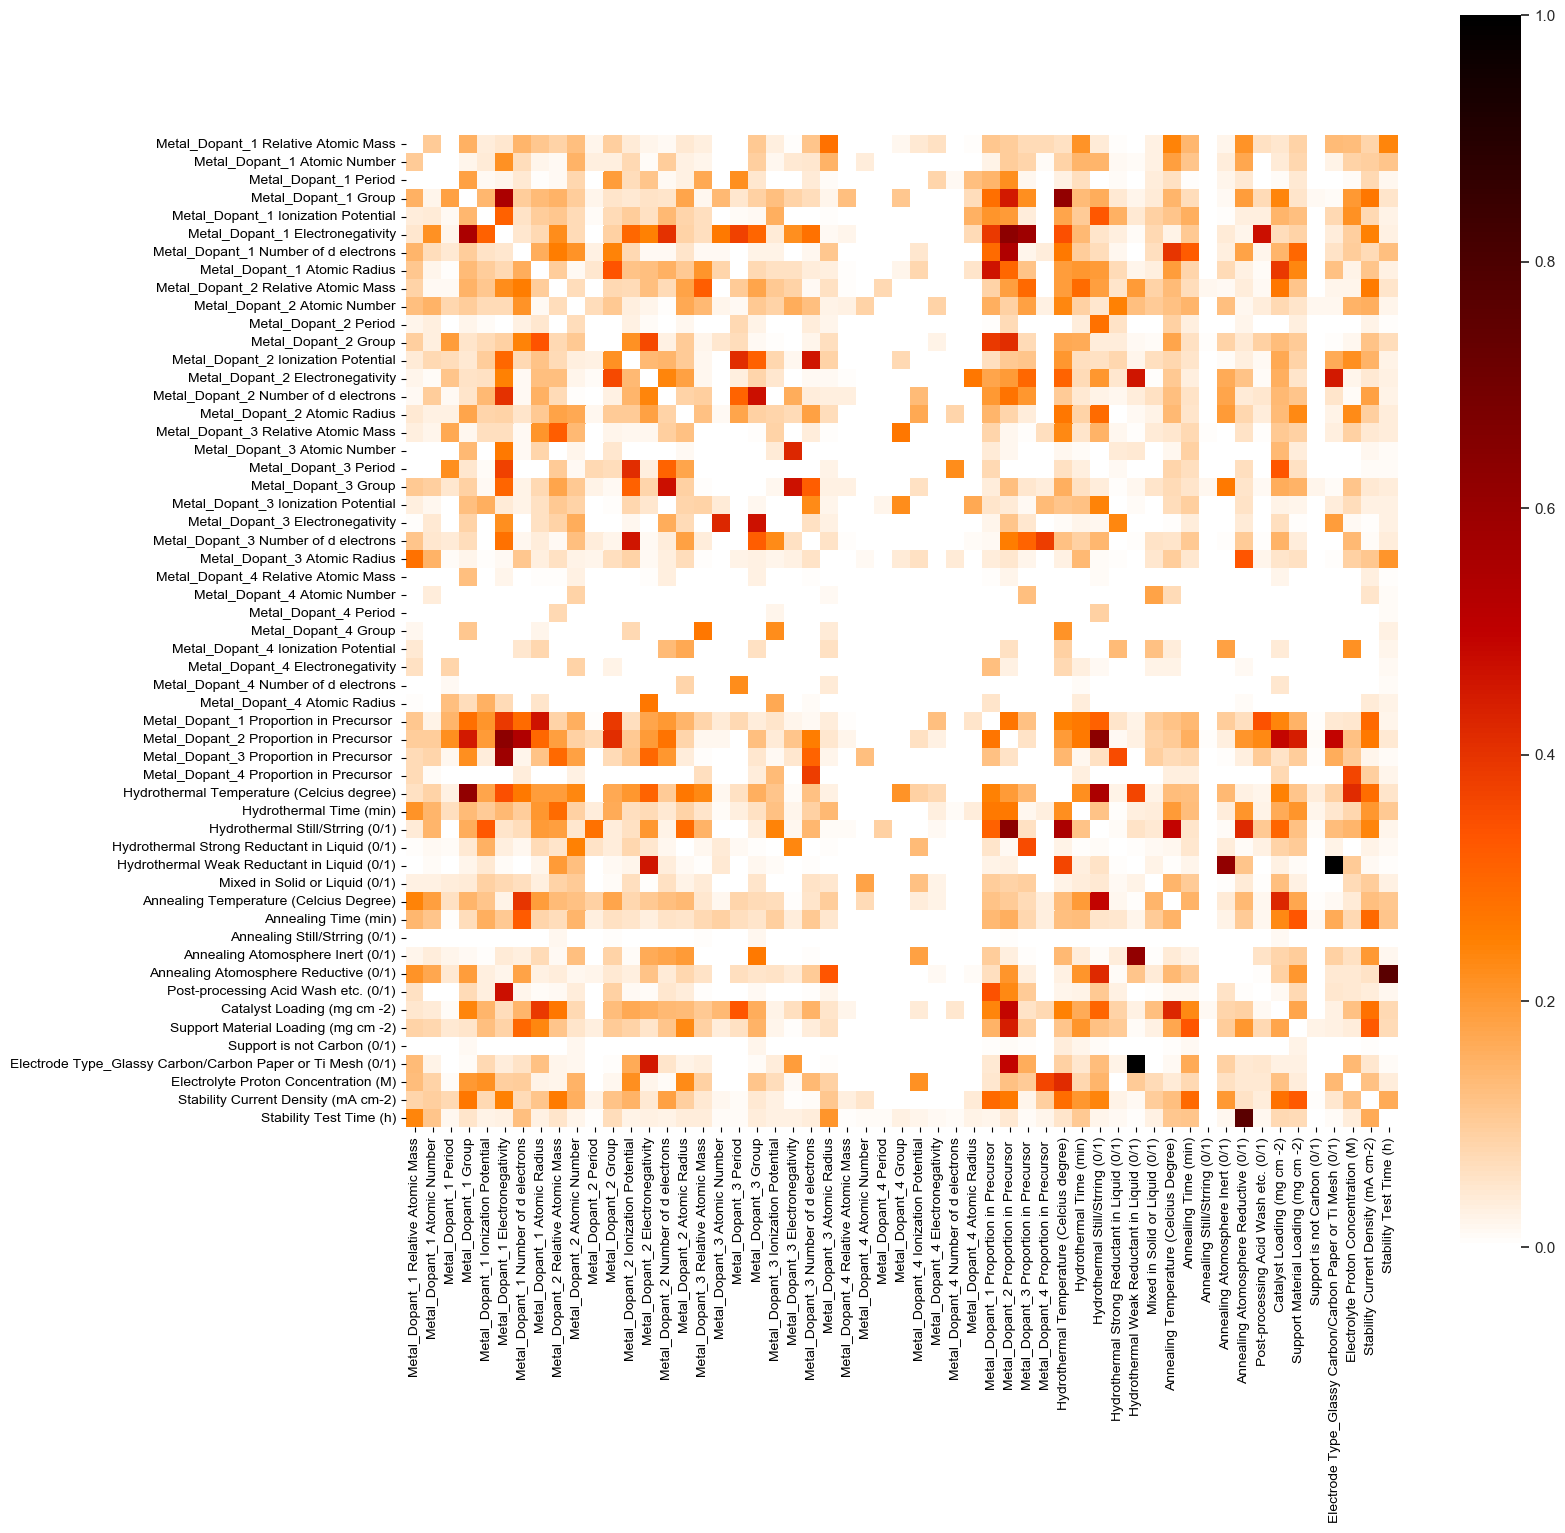

In [18]:
import seaborn as sns

f, ax= plt.subplots(figsize = (16, 16))
sns.set(font_scale=1)
ax=sns.heatmap(Weighted_Matrix,annot=False, vmax=1,vmin = 0, xticklabels= True, yticklabels= True, square=True, cmap="gist_heat_r")

In [19]:
Element_M=Weighted_Matrix.iloc[0:36,0:36]
Synthesis_M=Weighted_Matrix.iloc[36:55,36:55]

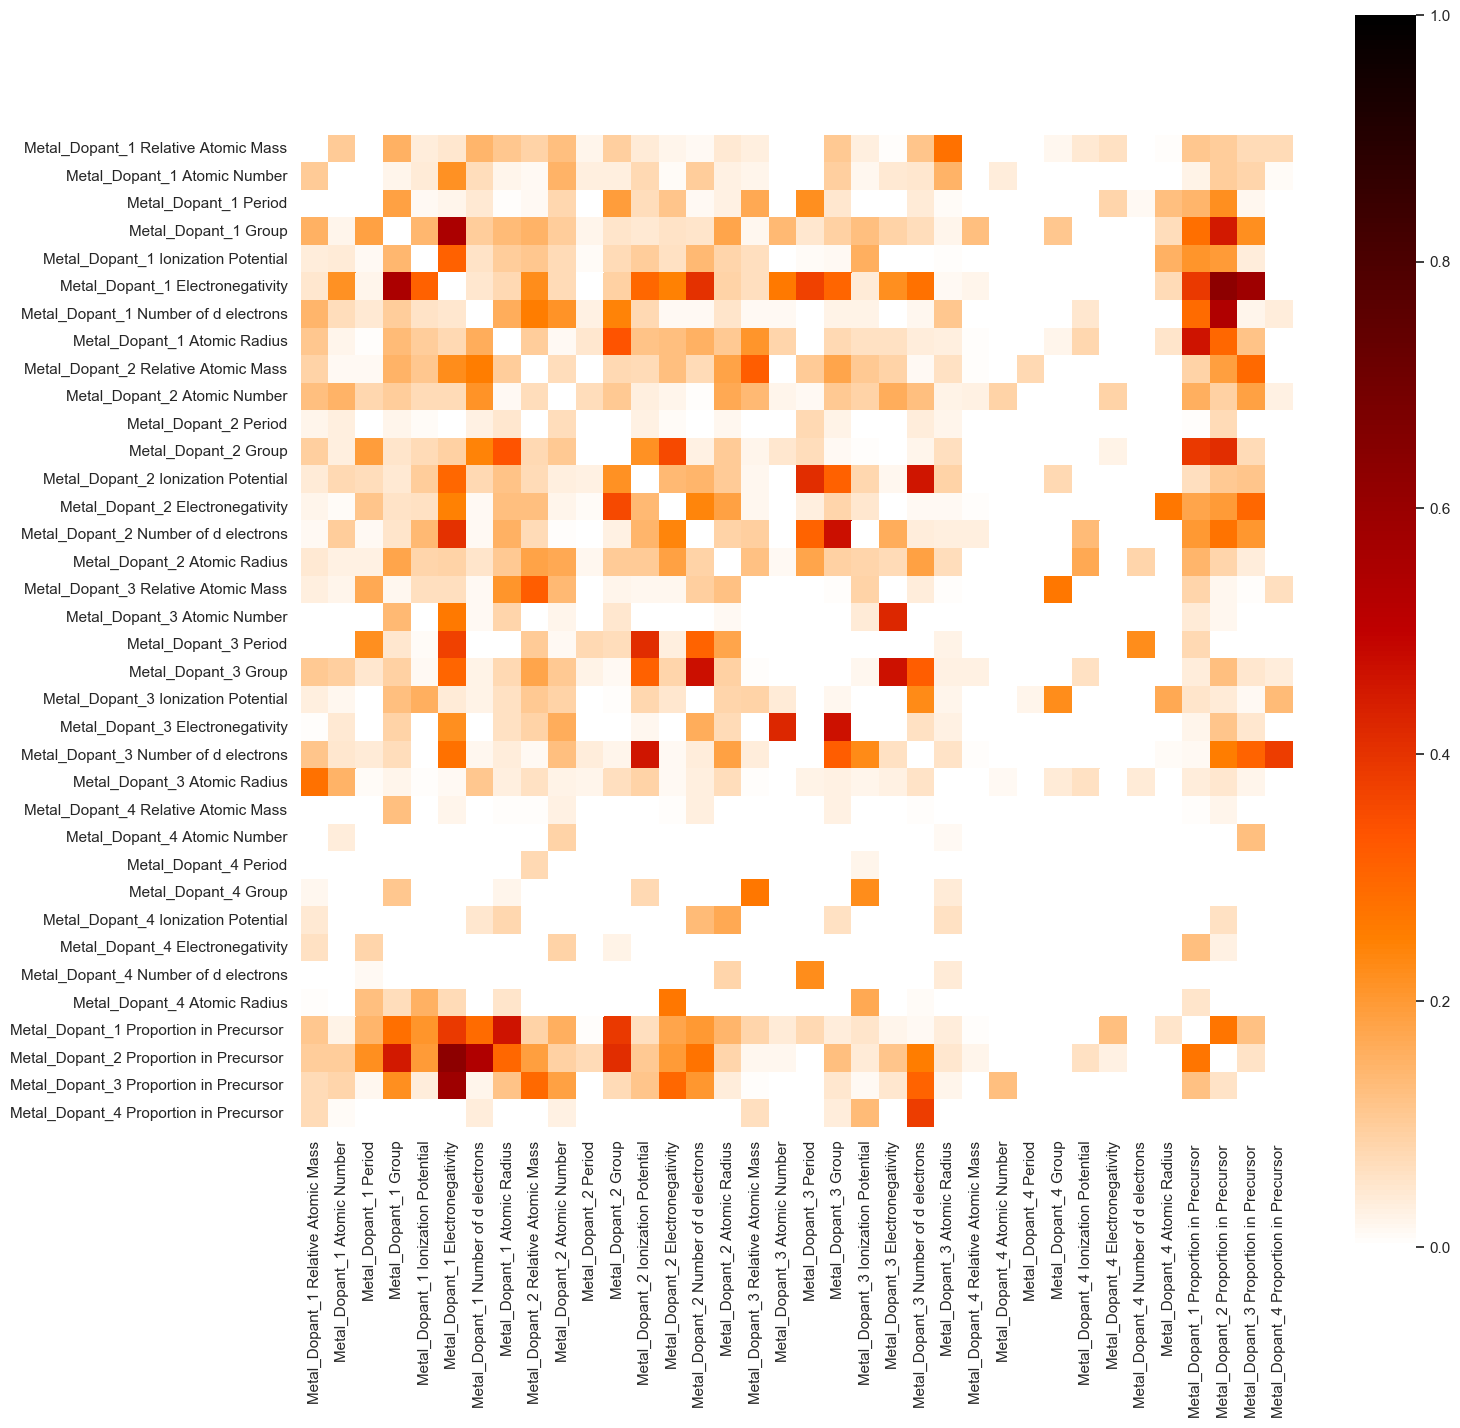

In [20]:
f1, ax1= plt.subplots(figsize = (16, 16))
# sns.set(font_scale=2)
ax1=sns.heatmap(Element_M,annot=False, vmax=1,vmin = 0, xticklabels= True, yticklabels= True, square=True, cmap="gist_heat_r")

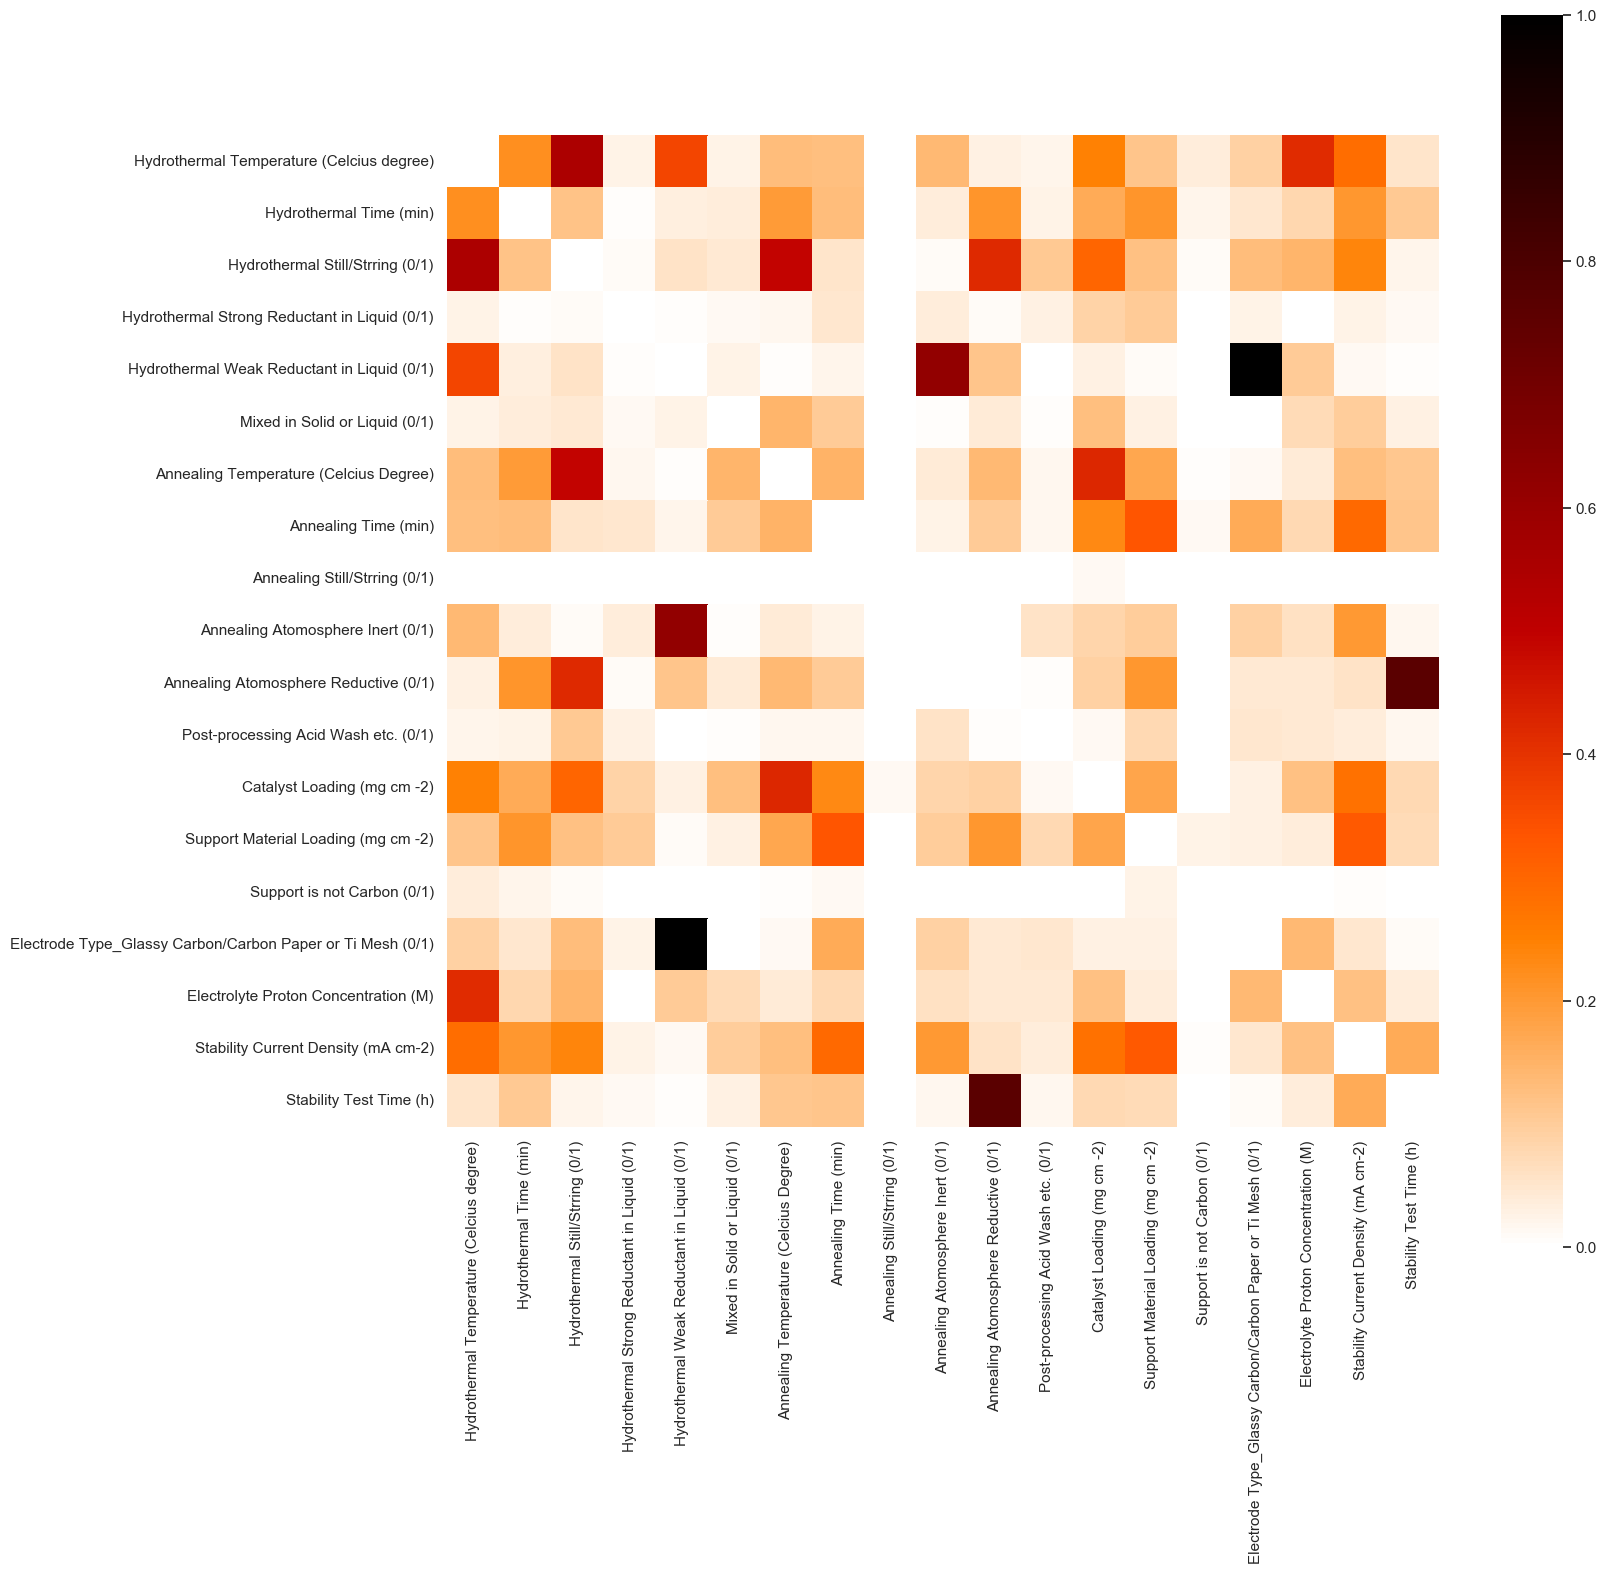

In [21]:
f2, ax2= plt.subplots(figsize = (16, 16))
# sns.set(font_scale=2)
ax2=sns.heatmap(Synthesis_M,annot=False, vmax=1,vmin = 0, xticklabels= True, yticklabels= True, square=True, cmap="gist_heat_r")